In [1]:
#imports
from cnn import *
import time
from timeit import timeit,Timer
from GameController import *
#import itertools
import sys
#import objgraph
import os
import psutil
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import clear_output
#import objgraph
process = psutil.Process(os.getpid())

In [2]:
#Modified Functions
#infer_action
#get_seq_y
#train_network

#Relevant Functions
def infer_action(seq):
    action = tf.get_default_graph().get_tensor_by_name("action:0")
    q_compute = tf.get_default_graph().get_tensor_by_name("Qnext_val:0")
    outputs = tf.get_default_graph().get_tensor_by_name("dense_layers/FC2/act2/Maximum:0")
    x1,y,next_state_bool,Qnext= get_place_holders()
    #return sess.run([action],{x1: seq,x2: np.random.rand(1,110,84,4),next_state_bool: False})
    a,q,o = sess.run([action,q_compute,outputs],{x1: seq})
    return a

def send_action_to_game_controller(game,a):
    if (a == 0):
        game.move_mouse_up()
    elif (a == 1):
        game.move_mouse_down()
    elif (a == 2):
        game.move_mouse_left()
    elif (a == 3):
        game.move_mouse_right()
    else:
        x = 1
        # Do Nothing
    
    r = game.reward
    frames,bval = get_4_frames(game)
    return r,frames,bval

def random_minibatch_sample(batchsize):
    global exp
    
    line_N = np.random.randint(0,len(exp),size=batchsize)
    return np.asarray([exp[i] for i in line_N]).transpose()
    
def get_seq_y(seq,batch_size,gamma):
    q_compute = tf.get_default_graph().get_tensor_by_name("Qnext_val:0")
    x1,y,next_state_bool,Qnext = get_place_holders()
    #1.0/256
    
    imgs_2 = [((1.0)*np.array(seq[3,i])).astype(np.float16) for i in range(0,batch_size)]
    imgs_1 = [((1.0)*np.array(seq[0,i])).astype(np.float16) for i in range(0,batch_size)]
    
    q_vals = sess.run([q_compute],{x1: imgs_2})
    r_vals = [seq[2,i] for i in range(0,batch_size)]
    
    q_vals = np.array(q_vals)
    r_vals = np.array(r_vals)
    y = (r_vals+(gamma*q_vals)).reshape(len(r_vals),1)
    return y,np.squeeze(np.array(imgs_1))
    
def store_exp(seq):
    global exp
    exp.append(seq)
    return

def train_network(batch_size,gamma):
    #Required tensorflow variables and operations
    global writer,summ,it
    x1,y,next_state_bool,Qnext = get_place_holders()
    train = tf.get_default_graph().get_operation_by_name("train/trainer")
    seq = random_minibatch_sample(batch_size)
    y_vals,images = get_seq_y(seq,batch_size,gamma)
    images = np.squeeze(images)
    t,s = sess.run([train,summ],{x1: images, Qnext: y_vals})
    writer.add_summary(s,it)
    it = it+1
    return

def get_4_frames(game):
    imgs = np.concatenate((take_shot(game),
                         take_shot(game),
                         take_shot(game),
                         take_shot(game)),axis=2)
    bval = game.get_screen_number2(np.array(imgs))
    rtnbool = True if bval else False
    return imgs,rtnbool

def add_to_queue(frames):
    global writer,summ,i
    q = tf.get_default_graph().get_operation_by_name("FIFOQueue/Train_Queue")
    q.enqueue(frames)

In [3]:
#Train/Play Fucnction
def run(game,greed,M,batch_size,gamma):
    global exp
    t_a = []
    for i in range(0,M):  #New play
        clear_output(wait=True)
        if (i % 50 == 0):
            if (greed >= .2):
                greed = greed-.2
            else:
                greed = .1
        wait_for(1)
        p = 0
        t = time.time()
        game.click_to_play()
        while game.get_screen_number(take_shot(game)): #for j in range(0,T): #While play active
            frames1,test = get_4_frames(game)
            if (not test):
                break
            a = np.asarray(np.random.randint(0,5)).astype(np.uint8) if (np.random.random_sample(1) <= greed) else np.asarray(infer_action([frames1])).astype(np.float16)
            r,frames2,test = send_action_to_game_controller(game,a)
            if (not test):
                break
            store_exp((frames1,np.array(a).astype(np.uint8),np.array(r).astype(np.float16),frames2))
            if (len(exp) > 5):
                #add_to_train_queue(batch_size)
                train_network(batch_size,gamma)
        game.release_click()
        t_a.append(time.time()-t)
        wait_for(.3)
        game.click_replay()
        print("Iteration: ",i)
        print("Greed: ",greed)
        #print("size: ",len(exp))
        #print("size bytes: ",sys.getsizeof(exp))
        print("mem: ",(process.memory_info().rss)/1e6)
    return t_a

def play_game(game,M):
    for i in range(0,M):
        wait_for(1)
        game.click_to_play()
        while game.get_screen_number2(take_shot(game)):
            frames,test = get_4_frames(game)
            if (not test):
                break
            a = infer_action([frames])
            r,frames,test = send_action_to_game_controller(game,a)
            if (not test):
                break
        game.release_click()
        wait_for(.3)
        game.click_replay()
        print("Play Iteration: ",i)

In [4]:
def data_generator():
    global exp
    line_N = np.random.randint(0,len(exp),size=32)
    seq = np.asarray([exp[i] for i in line_N]).transpose()
    #y_vals,images = get_seq_y(seq,32,.9)
    yield seq


In [5]:
#[8,4] [4,2]
conv_k_size = [8,4]
conv_stride = [4,2]
conv = [0,16,32]
fclyr = [0,125,5]
conv_count = len(conv)
fc_count = len(fclyr)
learning_rate = 1e-4
batch_size = 10
LOGDIR = r"c:\Users\Vishnu\Documents\EngProj\SSPlayer\log1k2"
sess,writer,summ,place_holders= create_model(learning_rate,data_generator,batch_size,conv_count,fc_count,conv,fclyr,conv_k_size,conv_stride,LOGDIR)
writer.add_graph(sess.graph)
print(tf.get_default_graph().get_tensor_by_name("Qnext_val:0"))

TypeError: Incompatible return types of true_fn and false_fn: The two structures don't have the same nested structure.

First structure: type=list str=[<tf.Tensor 'cond/Const:0' shape=() dtype=float16>, <tf.Tensor 'place_holder/x1:0' shape=(?, 110, 84, 4) dtype=float16>]

Second structure: type=tuple str=(<tf.Tensor 'IteratorGetNext:0' shape=() dtype=float16>, <tf.Tensor 'IteratorGetNext:1' shape=<unknown> dtype=float16>)

More specifically: The two namedtuples don't have the same sequence type. First structure type=list str=[<tf.Tensor 'cond/Const:0' shape=() dtype=float16>, <tf.Tensor 'place_holder/x1:0' shape=(?, 110, 84, 4) dtype=float16>] has type list, while second structure type=tuple str=(<tf.Tensor 'IteratorGetNext:0' shape=() dtype=float16>, <tf.Tensor 'IteratorGetNext:1' shape=<unknown> dtype=float16>) has type tuple

In [5]:
it = 0
exp = []
app_dir = r"C:\Users\Vishnu\Documents\EngProj\SSPlayer\Release.win32\ShapeScape.exe"
if it:
    if __name__ == "__main__":
        game = SSPlayer(app_dir,1)
        wait_for(1)
        print("Game Byte Size: ",sys.getsizeof(game))
        game.click_play()
        t_a = run(game,.9,2,2,.9)
        p_i = np.arange(0,2,1)
        #play_game(game,15)
        #sess.close()
        game.kill()
#[128,192,192,264,264]

Iteration:  1
Greed:  0.7
mem:  193.39264


In [7]:
#Other Functions
def save_imgs(exp):
    img_1 = [(250*((1.0/256)*np.array(exp[i][0]))).astype(np.uint8) for i in range(0,len(exp))]
    img_2 = [(250*((1.0/256)*np.array(exp[i][3]))).astype(np.uint8) for i in range(0,len(exp))]
    
    print(np.shape(img_1))
    print(np.shape(img_2))
    
    imgs= []
    for i in img_1:
        imgs.append(i[:,:,0])
        imgs.append(i[:,:,1])
        imgs.append(i[:,:,2])
        imgs.append(i[:,:,3])
        
    
    for i in img_2:
        imgs.append(i[:,:,0])
        imgs.append(i[:,:,1])
        imgs.append(i[:,:,2])
        imgs.append(i[:,:,3])
        
    
    print(np.shape(imgs))
    print(sys.getsizeof(imgs)/1000)
    for i in range(0,len(imgs)):
        Image.fromarray(imgs[i]).save(r"test\frame"+str(i)+".png")
    return
        
def test_seq(game,batch_size):
    seq = []
    for i in range(0,batch_size):
        frames,t = get_4_frames(game,game.processing_crop)
        seq.append(frames)
        seq.append(np.random.randint(0,4))
        seq.append(np.random.random_sample(1))
        frames,t = get_4_frames(game,game.processing_crop)
        seq.append(frames)
    return seq

def test():
    x1,y,next_state_bool,Qnext = get_place_holders()
    train = tf.get_default_graph().get_operation_by_name("train/trainer")
    dummy = np.random.rand(32,110,84,4)
    y_vals = np.random.rand(32,1)
    sess.run([train],{x1: dummy,Qnext: y_vals})
    return

if False:
    print(Timer(lambda: test()).timeit(number=1))
    
def store_test_data(length):
    global exp
    for i in range(0,length):
        exp.append((np.random.rand(1,110,84,4).astype(np.float16),
                    np.random.randint(0,4),
                    np.random.rand(1).astype(np.float16),
                    np.random.rand(1,110,84,4).astype(np.float16)))
    return

    
def test_new():
    train = tf.get_default_graph().get_operation_by_name("train/trainer")
    sess.run([train])
    return

In [8]:
exp = []
store_test_data(50)
print(len(exp))

50


In [9]:
print(Timer(lambda: random_minibatch_sample(32)).timeit(number=1))

9.237314645695434e-05


In [8]:
x = 0
if x:
    game = SSPlayer(app_dir,2)
    wait_for(1)
    game.click_play()
    wait_for(1)
    play_game(game,15)
    game.kill()

ValueError: x and y must have same first dimension, but have shapes (2,) and (19,)

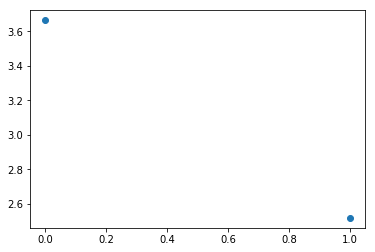

In [9]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
if it:
    plt.plot(p_i, t_a,'o')
    plt.plot(p_i, smooth(t_a,19), 'r-', lw=2)
    plt.show()